In [ ]:
# Check CUDA Version
!python -c "import torch; print(torch.version.cuda)"

# Install Pytorch Geometric
!pip install -q torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip install -q torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.6.0.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

In [4]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

Processing...
Done!


In [5]:
print(f"Number of graphs = {len(dataset)}")
print(f"Number of features = {dataset.num_features}")
print(f"NUmber of classes = {dataset.num_classes}")
print(50*"=")

data = dataset[0]

print(data)

Number of graphs = 1
Number of features = 1433
NUmber of classes = 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [6]:
 print(data.edge_index.t())

tensor([[   0,  633],
        [   0, 1862],
        [   0, 2582],
        ...,
        [2707,  598],
        [2707, 1473],
        [2707, 2706]])


## Graph Neural Network

In [7]:
import torch
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv


In [19]:
class GCN(nn.Module):
  def __init__(self, hidden_channels):
    super(GCN, self).__init__()
    torch.manual_seed(42)

    ## Initializing the layers
    self.conv1 = GCNConv(dataset.num_features, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, hidden_channels)
    self.out = Linear(hidden_channels, dataset.num_classes)


  def forward(self, x, edge_index):
    # First Message passing layer (Transformation)
    x = self.conv1(x, edge_index)
    x = x.relu()
    x = F.dropout(x, p =  0.5, training = self.training)

    # Second Message passing Layer
    x = self.conv2(x, edge_index)
    x = x.relu()
    x = F.dropout(x, p = 0.5, training = self.training)

    #Output layer
    x = F.softmax(self.out(x), dim = 1)
    return x


model = GCN(hidden_channels = 16)
print(model)


GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (out): Linear(in_features=16, out_features=7, bias=True)
)


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [21]:
model.to(device)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 16)
  (out): Linear(in_features=16, out_features=7, bias=True)
)

In [22]:
data = data.to(device)

In [27]:
learning_rate = 1e-1
decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(),
                             lr = learning_rate,
                             weight_decay = decay)

criterion = nn.CrossEntropyLoss()


In [28]:
def train():
  model.train()
  optimizer.zero_grad()
  out = model(data.x, data.edge_index)
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  return loss

def test():
  model.eval()
  out = model(data.x, data.edge_index)
  pred = out.argmax(dim = 1)
  test_correct = pred[data.test_mask] == data.y[data.test_mask]
  test_acc = int(test_correct.sum())/ int(data.test_mask.sum())
  return test_acc

In [29]:
losses = []
for epoch in range(1000):
  loss = train()
  losses.append(loss)
  if epoch %100 == 0:
    print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}")

Epoch: 000, Loss: 1.3488
Epoch: 100, Loss: 1.4649
Epoch: 200, Loss: 1.3836
Epoch: 300, Loss: 1.3841
Epoch: 400, Loss: 1.3205
Epoch: 500, Loss: 1.3469
Epoch: 600, Loss: 1.3058
Epoch: 700, Loss: 1.3267
Epoch: 800, Loss: 1.3452
Epoch: 900, Loss: 1.3162


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

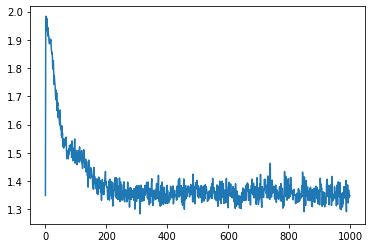

In [30]:
import seaborn as sns
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(loss_indices, losses_float)
plt

In [31]:
test_acc = test()
test_acc

0.757

torch.Size([2708, 7])


<AxesSubplot:>

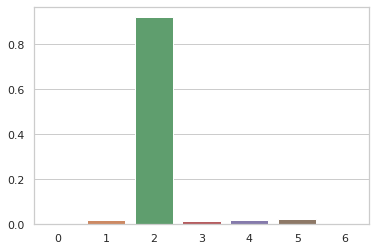

In [32]:
import seaborn as sns
import numpy as np
sample = 9
sns.set_theme(style="whitegrid")
print(model(data.x, data.edge_index).shape)
pred = model(data.x, data.edge_index)
sns.barplot(x=np.array(range(7)), y=pred[sample].detach().cpu().numpy())

## Visualizing

In [33]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def plt2arr(fig):
    rgb_str = fig.canvas.tostring_rgb()
    (w,h) = fig.canvas.get_width_height()
    rgba_arr = np.fromstring(rgb_str, dtype=np.uint8, sep='').reshape((w,h,-1))
    return rgba_arr


def visualize(h, color, epoch):
    fig = plt.figure(figsize=(5,5), frameon=False)
    fig.suptitle(f'Epoch = {epoch}')
    # Fit TSNE with 2 components
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    # Create scatterplot from embeddings
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], 
                z[:, 1], 
                s=70, 
                c=color.detach().cpu().numpy(), 
                cmap="Set2")
    fig.canvas.draw()

    # Convert to numpy
    return plt2arr(fig)


# Reset the previously trained model weights
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

tensor([[5.4505e-09, 1.7550e-10, 1.5308e-01,  ..., 1.3489e-10, 2.2601e-12,
         2.2766e-02],
        [3.5428e-03, 1.8872e-07, 2.0998e-10,  ..., 9.9143e-01, 1.9088e-10,
         6.8585e-08],
        [1.1201e-01, 1.0253e-02, 2.8602e-04,  ..., 7.8158e-01, 2.0571e-04,
         3.8415e-04],
        ...,
        [5.8173e-03, 1.1824e-12, 4.2211e-14,  ..., 3.2840e-15, 9.7930e-01,
         1.4879e-02],
        [2.6807e-02, 1.4218e-04, 7.8899e-05,  ..., 2.4328e-01, 5.2382e-07,
         4.1326e-04],
        [1.1470e-02, 1.0670e-03, 2.2067e-03,  ..., 7.9864e-02, 1.8722e-05,
         4.1694e-03]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[4.4930e-03, 7.1976e-07, 9.7608e-06,  ..., 1.2079e-02, 2.1992e-09,
         1.0390e-04],
        [3.1700e-02, 2.7620e-07, 1.2429e-09,  ..., 9.4373e-01, 3.6902e-10,
         1.2288e-07],
        [4.4126e-02, 4.3217e-06, 2.7921e-07,  ..., 8.5274e-01, 3.2138e-08,
         5.1354e-06],
        ...,
        [1.9811e-02, 7.8339e-01, 3.8103e-02,  ..., 1.03

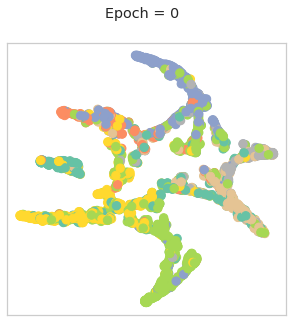

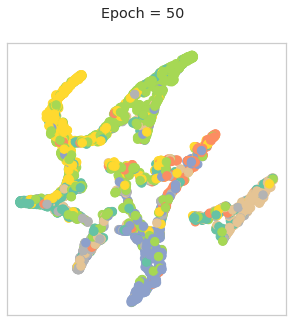

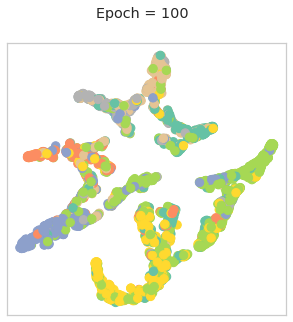

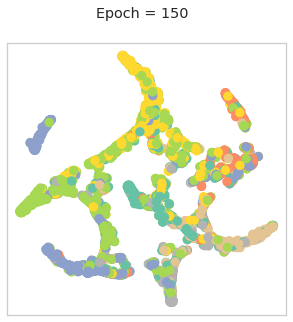

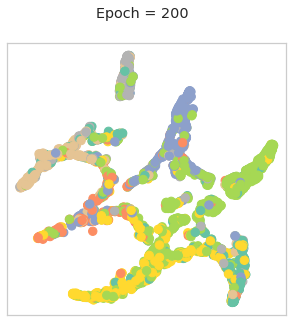

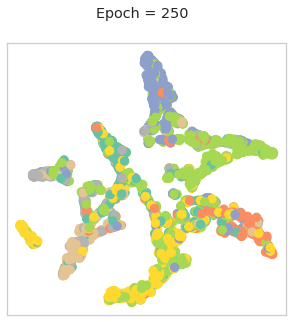

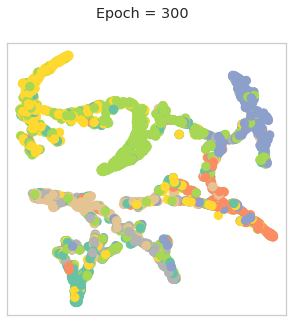

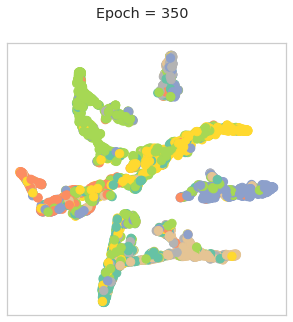

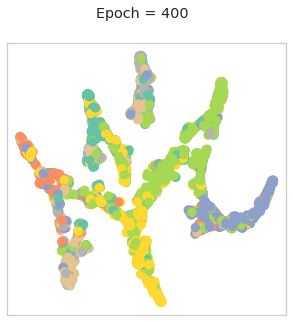

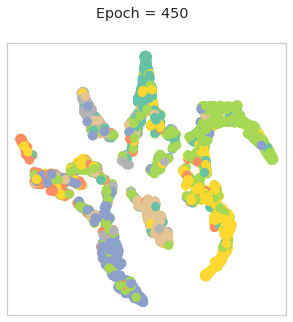

In [39]:
# Ignore deprecation warnings here
import warnings
warnings.filterwarnings('ignore')

# Train the model and save visualizations
images = []
for epoch in range(0, 500):
    loss = train()
    if epoch % 50 == 0:
      out = model(data.x, data.edge_index)
      images.append(visualize(out, color=data.y, epoch=epoch))
      print(out)
print("TSNE Visualization finished.")

In [46]:
!pip install moviepy==1.0.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 KB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110742 sha256=f7401df0da2d989de35a7352b41ff51c9fd7f27cb2cacd22b813f4fae68a2c03
  Stored in directory: /root/.cache/pip/wheels/e4/a4/db/0368d3a04033da662e13926594b3a8cf1aa4ffeefe570cfac1
Successfully built moviepy
  Attempting uninstall: moviepy
    Found existing installation: moviepy 0.2.3.5
    Uninstalling moviepy-0.2.3.5:
      Successfully uninstalled moviepy-0.2.3.5


In [47]:
from moviepy.editor import ImageSequenceClip
fps = 1
filename = "/content/embeddings.gif"
clip = ImageSequenceClip(images, fps=fps)
clip.write_gif(filename, fps=fps)

MoviePy - Building file /content/embeddings.gif with imageio.


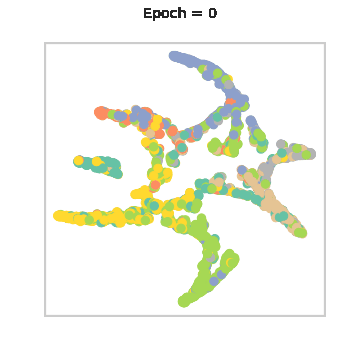

In [48]:
from IPython.display import Image
with open('/content/embeddings.gif','rb') as f:
    display(Image(data=f.read(), format='png'))